# descriptive stats on data

- it became clear from the feature engineering and trying to run a simple linear model that the size of the data is cumbersome

- moved from ml.m52xlarget to ml.m5.4xlarge

- the number of observations in the test data is 15 days
- in the training it was 1687 days


- we have established that the items have to be pooled in some way to account for the sparsity of observations for some items
    * at least for all stores and likely by item grouping
   
- model is regression based models , gradient boosted decision trees according to learnings from kaggle forecasting competitions (Bojer and Meldgaard)

- neural networks
    
    

# stratification for modelling
- start with the simplest which is regression by item pooled across store
- indicator for has the item been sold in this store previously


- given time constraints am going to run lstm neural network model 
- with multioutput 
-

reference: 
- https://machinelearningmastery.com/multi-output-regression-models-with-python/ 
- https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/
- https://www.tensorflow.org/tutorials/structured_data/time_series
Chollet

In [302]:
import pandas as pd
import numpy as np

In [303]:
%%time
df_train = pd.read_feather("data/trainpy.feather")
df_test = pd.read_csv("data/test.csv") 

CPU times: user 8.31 s, sys: 5.7 s, total: 14 s
Wall time: 5.91 s


In [304]:
df_train.head()

id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0        None
1   1  2013-01-01         25    105574         1.0        None
2   2  2013-01-01         25    105575         2.0        None
3   3  2013-01-01         25    108079         1.0        None
4   4  2013-01-01         25    108701         1.0        None

In [305]:
df_train[:10]

id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0        None
1   1  2013-01-01         25    105574         1.0        None
2   2  2013-01-01         25    105575         2.0        None
3   3  2013-01-01         25    108079         1.0        None
4   4  2013-01-01         25    108701         1.0        None
5   5  2013-01-01         25    108786         3.0        None
6   6  2013-01-01         25    108797         1.0        None
7   7  2013-01-01         25    108952         1.0        None
8   8  2013-01-01         25    111397        13.0        None
9   9  2013-01-01         25    114790         3.0        None

In [306]:
#dfmatrix = df_train.pivot_table(values='unit_sales', index='item_nbr', columns='store_nbr', aggfunc='count')


In [307]:
#print(dfmatrix.shape)
#type(dfmatrix)
#dfmatrix.to_csv("output/entries_by_items_stores.csv")

In [308]:
#sample = X_train.sample()

In [309]:
train_items = df_train['item_nbr'].unique()
test_items = df_test['item_nbr'].unique()

In [310]:
type(train_items)

numpy.ndarray

In [311]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
 

In [312]:
items = intersection(train_items, test_items)
len(items)

3841

In [313]:
#https://realpython.com/python-sets/
items_not_in_train = list(set(test_items).difference(train_items))
items_not_in_test = list(set(train_items).difference(test_items))
print("items not in train:", len(items_not_in_train))
print("items not in test (ignore):", len(items_not_in_test))

items not in train: 60
items not in test (ignore): 195


In [314]:
from random import sample
item = sample(items,1)[0]
item

2016407

In [315]:
df_train_i = df_train[df_train['item_nbr'] == 1956004]
df_test_i = df_test[df_test['item_nbr'] == 1956004]
data = pd.concat([df_train_i, df_test_i])

In [316]:
data.shape

(12704, 6)

In [317]:
len(data['store_nbr'].unique())

54

In [318]:
data

id        date  store_nbr  item_nbr  unit_sales onpromotion
67433669   67433669  2016-01-12          7   1956004         4.0       False
67613006   67613006  2016-01-14          7   1956004         6.0       False
67638493   67638493  2016-01-14         24   1956004         6.0       False
67675626   67675626  2016-01-14         47   1956004         5.0       False
67701435   67701435  2016-01-15          7   1956004         2.0       False
...             ...         ...        ...       ...         ...         ...
3354062   128851102  2017-08-31         50   1956004         NaN       False
3357963   128855003  2017-08-31         51   1956004         NaN        True
3361864   128858904  2017-08-31         52   1956004         NaN        True
3365765   128862805  2017-08-31         53   1956004         NaN       False
3369666   128866706  2017-08-31         54   1956004         NaN       False

[12704 rows x 6 columns]

In [319]:
dt = data.pivot(values='unit_sales', index=['date'], columns='store_nbr')



In [320]:
df = dt.fillna(0)
print(df.columns)
df.index = pd.to_datetime(df.index)
df

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54],
           dtype='int64', name='store_nbr')


store_nbr    1    2    3    4    5    6    7    8    9    10  ...   45   46  \
date                                                          ...             
2016-01-12  0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-14  0.0  0.0  0.0  0.0  0.0  0.0  6.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-15  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-16  0.0  0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-17  0.0  0.0  7.0  0.0  4.0  0.0  2.0  0.0  0.0  0.0  ...  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2017-08-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-31  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

store_nbr    47   48   49   50   51   52   53   54  
date                                                
2016-01-12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-14  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-15  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-16  4.0  6.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-17  6.0  9.0  0.0  0.0  0.0  0.0  0.0  0.0  
...         ...  ...  ...  ...  ...  ...  ...  ...  
2017-08-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-31  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[595 rows x 54 columns]

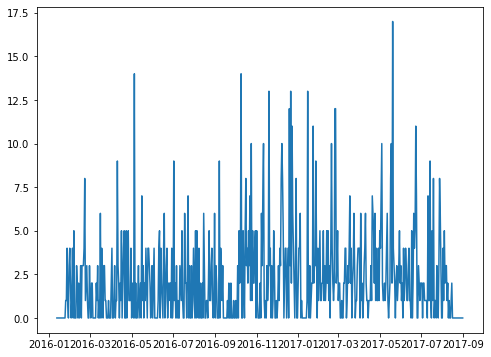

In [321]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))


plt.plot(df[1].index, df[1].values)

In [322]:
!pip install keras
!pip install tensorflow
from keras.layers import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [323]:
from datetime import datetime 
cutoff = datetime.strptime('2017-08-16', "%Y-%m-%d")
df = df.loc[df.index < cutoff, :]

In [324]:
df = df.values
df.shape

(579, 54)

In [325]:
df

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  7.,  8., ..., 19.,  0.,  0.],
       [ 1.,  3.,  7., ...,  6.,  0.,  0.],
       [ 2.,  1., 10., ..., 12.,  0.,  0.]])

In [326]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(df) # setting scaler data between 0 - 1 

In [327]:
#scaled_df = scaler.transform(df)
scaled_df = df
scaled_df.shape

(579, 54)

In [328]:
scaled_df

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  7.,  8., ..., 19.,  0.,  0.],
       [ 1.,  3.,  7., ...,  6.,  0.,  0.],
       [ 2.,  1., 10., ..., 12.,  0.,  0.]])

In [329]:
"""
start_index: usually 0
end_index: Train Split
history_size: window
target_size: how far into future
"""

'\nstart_index: usually 0\nend_index: Train Split\nhistory_size: window\ntarget_size: how far into future\n'

In [330]:
dlist = dt.index

In [331]:
def create_data_v(data, lags, start, end, target_size):
  x_data = []
  y_data = [] 
  index = [i for i in range(0, len(data))]

  for i in range(start, end):
    x_data.append(data[i-lags:i])
    y_data.append(data[i:i+target_size])
    if (i < start + 5) or (i >= end - 5):
      print("i: %s (%s), x: %s-%s, y: %s-%s" % (i, dlist[index[i]], i-lags, i-1, i, i+target_size))

  print(f"start: {start}, end: {end}, lags: {lags}, target_size {target_size}")
  return(np.array(x_data), np.array(y_data))

In [332]:
#taking a split of 80/20
split = int(len(scaled_df) * 0.8)
split

463

In [333]:
#past_history = 365
#future_target = 273
#STEP = 1

lags = 50
start = lags
end = split
target_size = 15

In [334]:
X_train, y_train = create_data_v(scaled_df, lags, start, end, target_size)

i: 50 (2016-03-03), x: 0-49, y: 50-65
i: 51 (2016-03-04), x: 1-50, y: 51-66
i: 52 (2016-03-05), x: 2-51, y: 52-67
i: 53 (2016-03-06), x: 3-52, y: 53-68
i: 54 (2016-03-07), x: 4-53, y: 54-69
i: 458 (2017-04-17), x: 408-457, y: 458-473
i: 459 (2017-04-18), x: 409-458, y: 459-474
i: 460 (2017-04-19), x: 410-459, y: 460-475
i: 461 (2017-04-20), x: 411-460, y: 461-476
i: 462 (2017-04-21), x: 412-461, y: 462-477
start: 50, end: 463, lags: 50, target_size 15


In [335]:
y_train.shape
X_train.shape

(413, 50, 54)

In [336]:
start = split
end = len(df) - target_size

X_test, y_test = create_data_v(scaled_df, lags, start, end, target_size)

i: 463 (2017-04-22), x: 413-462, y: 463-478
i: 464 (2017-04-23), x: 414-463, y: 464-479
i: 465 (2017-04-24), x: 415-464, y: 465-480
i: 466 (2017-04-25), x: 416-465, y: 466-481
i: 467 (2017-04-26), x: 417-466, y: 467-482
i: 559 (2017-07-27), x: 509-558, y: 559-574
i: 560 (2017-07-28), x: 510-559, y: 560-575
i: 561 (2017-07-29), x: 511-560, y: 561-576
i: 562 (2017-07-30), x: 512-561, y: 562-577
i: 563 (2017-07-31), x: 513-562, y: 563-578
start: 463, end: 564, lags: 50, target_size 15


In [337]:
#!pip install xgboost
#from xgboost import XGBRegressor 


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [338]:
import sklearn.linear_model as lm
m = lm.LinearRegression()

In [339]:
print(X_train.shape)
print(X_train[0])

(413, 50, 54)
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 3.  0. 13. ...  0.  1.  0.]
 [ 1.  1.  3. ...  0.  0.  0.]
 [ 0.  1.  4. ...  0.  0.  0.]]


In [340]:
X_train[0].shape[0]

50

In [341]:
print(y_train.shape)
print(X_train.shape)
#y_train.reshape(1, -1)[0].shape
print(X_test.shape)
print(y_test.shape)

(413, 15, 54)
(413, 50, 54)
(101, 50, 54)
(101, 15, 54)


In [342]:
# n is the sliding window
n = 50
i = n

predictions = list()
xt = pd.DataFrame()
yt = pd.DataFrame()

for i in range(0, X_train.shape[0]-1):
    #print(X_train[i].T.shape)
    xt = xt.append(pd.DataFrame(X_train[i].T))
    yt = yt.append(pd.DataFrame(y_train[i].T))

xt.head()
yt.head()



0    1    2     3    4    5     6     7    8    9     10   11   12   13  \
0  2.0  2.0  0.0   0.0  0.0  0.0   0.0   2.0  1.0  3.0   0.0  1.0  0.0  6.0   
1  4.0  5.0  2.0  13.0  4.0  2.0  10.0   2.0  2.0  6.0   5.0  3.0  2.0  5.0   
2  3.0  2.0  6.0  27.0  4.0  4.0  15.0  19.0  3.0  1.0  13.0  9.0  2.0  3.0   
3  0.0  0.0  0.0   0.0  0.0  0.0   0.0   6.0  5.0  2.0   6.0  0.0  0.0  1.0   
4  0.0  1.0  0.0   4.0  2.0  5.0   8.0   0.0  0.0  1.0   0.0  0.0  0.0  0.0   

    14  
0  0.0  
1  3.0  
2  2.0  
3  1.0  
4  0.0

In [343]:
xt.shape

(22248, 50)

In [344]:
m.fit(xt, yt)

LinearRegression()

In [345]:
xtt = pd.DataFrame()
ytt = pd.DataFrame()

for i in range(0, X_test.shape[0]-1):
    xtt = xtt.append(pd.DataFrame(X_test[i].T))
    ytt = ytt.append(pd.DataFrame(y_test[i].T))

preds = m.predict(xtt)

preds


array([[3.45608164, 2.66410585, 2.72550854, ..., 2.77878574, 3.00591147,
        2.72979189],
       [3.266534  , 3.95953464, 2.77245814, ..., 2.7117844 , 2.35190843,
        3.12958171],
       [9.07272646, 9.19272622, 7.78498441, ..., 8.01012124, 8.86185414,
        8.82971826],
       ...,
       [9.33149497, 7.55955345, 5.99278712, ..., 7.72080924, 8.47563054,
        8.73871496],
       [0.05339004, 0.0522168 , 0.0588369 , ..., 0.12002609, 0.09287307,
        0.11840715],
       [0.04639713, 0.05451165, 0.06014234, ..., 0.09290931, 0.09437662,
        0.09903812]])

In [346]:
print(preds.shape)
ytt.shape

(5400, 15)


(5400, 15)

In [347]:
preds.reshape

<function ndarray.reshape>

In [348]:
#def unscale(x):
#    return(scaler.inverse_transform(x.reshape(-1,1)).reshape(1,-1)[0])
#unscale(y_test)


In [349]:
"""
preds.r

def unscale(x):
    return(scaler.inverse_transform(x.reshape(-1,1)).reshape(1,-1)[0])

l = preds[0]
l
"""


'\npreds.r\n\ndef unscale(x):\n    return(scaler.inverse_transform(x.reshape(-1,1)).reshape(1,-1)[0])\n\nl = preds[0]\nl\n'

In [350]:
pdf = pd.DataFrame(preds)
pdf

0         1         2         3         4         5         6   \
0     3.456082  2.664106  2.725509  2.640109  2.228716  2.807962  2.962590   
1     3.266534  3.959535  2.772458  1.719385  1.964035  2.199669  2.568964   
2     9.072726  9.192726  7.784984  6.627423  7.944475  7.431130  8.835537   
3     6.848226  7.449025  4.667629  3.505175  5.380743  4.786372  4.137096   
4     1.178773  0.851031  0.563054  0.864651  1.355184  1.358915  1.291949   
...        ...       ...       ...       ...       ...       ...       ...   
5395  0.046397  0.054512  0.060142  0.066334  0.068908  0.073578  0.075504   
5396  4.099336  3.740485  3.579173  5.067581  4.969593  4.826863  5.022537   
5397  9.331495  7.559553  5.992787  5.969940  5.837561  7.621076  9.369150   
5398  0.053390  0.052217  0.058837  0.059461  0.128130  0.098109  0.061613   
5399  0.046397  0.054512  0.060142  0.066334  0.068908  0.073578  0.075504   

            7         8         9         10        11        12        13  \
0     2.804741  2.180229  2.504312  2.304416  2.164265  2.778786  3.005911   
1     2.898072  3.966376  2.252135  1.410642  1.585630  2.711784  2.351908   
2     8.652412  9.499494  7.218196  6.369873  8.069329  8.010121  8.861854   
3     7.207123  7.567037  4.545671  3.690563  4.965424  4.830221  4.266430   
4     1.158430  1.072904  0.765739  0.818084  1.425236  1.543252  1.379368   
...        ...       ...       ...       ...       ...       ...       ...   
5395  0.081215  0.086618  0.088436  0.089439  0.092441  0.092909  0.094377   
5396  4.249613  3.842748  3.477148  6.068071  5.254338  4.695784  4.975732   
5397  8.107435  7.753677  5.883933  6.413305  5.865611  7.720809  8.475631   
5398  0.086867  0.111130  0.099934  0.117029  0.165128  0.120026  0.092873   
5399  0.081215  0.086618  0.088436  0.089439  0.092441  0.092909  0.094377   

            14  
0     2.729792  
1     3.129582  
2     8.829718  
3     6.786243  
4     1.211377  
...        ...  
5395  0.099038  
5396  4.381216  
5397  8.738715  
5398  0.118407  
5399  0.099038  

[5400 rows x 15 columns]

In [351]:
ytt

0     1    2    3     4     5    6     7     8    9    10    11    12  \
0    5.0   2.0  6.0  1.0   4.0   1.0  1.0   4.0   1.0  5.0  4.0   7.0  10.0   
1    5.0   1.0  2.0  0.0   4.0   2.0  2.0   1.0   1.0  3.0  1.0  11.0   1.0   
2    9.0  11.0  3.0  1.0   1.0  11.0  4.0   2.0   5.0  7.0  7.0  19.0   3.0   
3    5.0   5.0  8.0  7.0  12.0   3.0  1.0   3.0   4.0  4.0  4.0   6.0   4.0   
4    1.0   0.0  0.0  0.0   0.0   0.0  0.0   3.0   4.0  0.0  0.0   3.0   0.0   
..   ...   ...  ...  ...   ...   ...  ...   ...   ...  ...  ...   ...   ...   
49   0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   
50   6.0   4.0  1.0  8.0   1.0   7.0  5.0   6.0   3.0  6.0  7.0   4.0   5.0   
51  14.0   8.0  8.0  4.0  11.0   9.0  7.0  11.0  11.0  8.0  8.0   5.0  10.0   
52   0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   
53   0.0   0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   

      13    14  
0    2.0   1.0  
1    2.0   4.0  
2    5.0   5.0  
3    0.0  12.0  
4    3.0   0.0  
..   ...   ...  
49   0.0   0.0  
50   3.0   6.0  
51  13.0  19.0  
52   0.0   0.0  
53   0.0   0.0  

[5400 rows x 15 columns]

In [352]:
np.mean(np.abs(pdf.values - ytt.values))

1.4317328093734725

In [353]:
from sklearn.tree import DecisionTreeRegressor

m = DecisionTreeRegressor()
m.fit(xt, yt)

preds = m.predict(xtt)

preds
pdf = pd.DataFrame(preds)
np.mean(np.abs(pdf.values - ytt.values))

2.008023422058035